# BM 336027 - Technion - Medical Image Processing


## Homework 2 - Edge Detection & Hough Transform 
---

### <a style='color:red'> Due Date: 8.5.2022 
</a>

Submitted on 9.5.2022. <br>
I'm sorry it is one day later than the deadline, i'll be grateful if you can check my work anyway. <br>
I'll understand if you deduct poins as a result of the late submission.

---
###  Agenda

* [Exercise 0: Gaussian Filter](#Exercise-0)
* [Exercise 1: Canny Edge Detection](#Exercise-1)
* [Exercise 2: Hough Transform](#Exercise-2)

#### Use as many cells as you need

### Submission Guidelines
---
* **No handwritten submissions.** 
* What you have to submit:
    * You should submit this file only, with the name: `bm_hw2_id.ipynb`.
    * No other file-types (`.py`, `.docx`...) will be accepted.
* Submission on the course website (Moodle).

In [1]:
# imports you will need
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from typing import Tuple
import cv2
%matplotlib inline

---

### **Assignment Instructions**
**In this assignment, you are allowed to use only basic numpy and matplotlib functions, and functions you implemented in other sections of the exercises (unless otherwise instructed)**

---

###  Exercise 0

In many cases, you might want to blur your image before using algorithms to process it.  
A good kernel you can use to blur an image is the Gaussian kernel.  
Implement a function `gaussian_kernel` that returns a Gaussian kernel for a given kernel size and std.
Write a description of your function and explain its inputs and output.

In [2]:
def gaussian_kernel(size: int, sigma: float) -> np.ndarray:
    '''
    The function gets a size and std and returns the suitable kernel 
    
    :param size: the size of the 2d kernel [size, size] in int type
    :param sigma: the std of the gaussian in float type
    :return gauss_kernel: numpy 2d array of a gaussian kernel 
    '''
    # ====== YOUR CODE: ======
    middle_index = np.median(range(size))
    gauss_kernel = np.zeros([size, size])

    for r_idx in range(size):
        for c_idx in range(size):
            
            r_dist_from_mid = (r_idx - middle_index)**2
            c_dist_from_mid = (c_idx - middle_index)**2
            
            gauss_kernel[r_idx, c_idx]= (1/(2 * np.pi * sigma**2)) * np.exp(-(r_dist_from_mid+c_dist_from_mid)/(2 * sigma**2))
    
    # ========================
    return gauss_kernel

----

###  Exercise 1

In this exercise, we'll Implement the Canny edge detector.  

1. First, we need to get the image gradients.  
   Implement the function `img_grad_sobel` that calculates the image gradient magnitude and direction. This function should return two arrays; one of the gradient magnitude and another of the gradient direction in radians. The gradient maps should have the same size as the input.  <br>
    Note: to avoid producing edges at the image's borders, use the reflection boundary condition.<br>
    You may use the `convolve2d` function of the scipy.signal package.  
    Write a description of your function and explain its inputs and output. 

 

In [3]:
def img_grad_sobel(img: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    '''
    The function calculates the gradient magnitude and direction of the input image.
    
    :param img: numpy array of an image
    :return magnitude: numpy array of the gradient magnitude of the image
    :return direction: numpy array of the gradient direction of the image
    '''
    
    # ====== YOUR CODE: ======    
    g_x = np.array([[1, 0 , -1],[2, 0, -2], [1, 0, -1]])
    g_y = np.array([[1, 2 , 1],[0, 0, 0], [-1, -2, -1]])
    
    f_x = signal.convolve2d(img, g_x, boundary='symm', mode='same')
    f_y = signal.convolve2d(img, g_y, boundary='symm', mode='same')
    
    magnitude = np.sqrt(f_x**2 + f_y**2)
    direction = np.arctan2(f_x, f_y) * (180/np.pi)
    
    # ========================
    
    return magnitude, direction

2. Load the image 'brain.jpg' and display it in one figure before and after using your function on it and add titles. <br>
The image might contain noise. Use the Gaussian kernel from exercise 0 and convolve it with the image to produce a cleaner image. Experiment to find good parameters for this operation.
Do not blur the image too much.

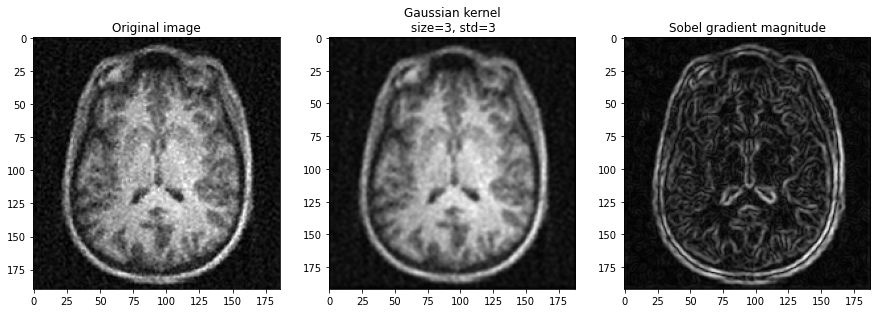

In [4]:
# ====== YOUR CODE: ======
s = 3
std = 3

plt.figure(figsize=(15,15))

plt.subplot(1,3,1)
brain_img = plt.imread('brain.jpg')
plt.title('Original image')
plt.imshow(brain_img, cmap='gray')

plt.subplot(1,3,2)
blured_img = signal.convolve2d(brain_img, gaussian_kernel(s, std))
plt.title(f'Gaussian kernel\n size={s}, std={std}')
plt.imshow(blured_img, cmap='gray')

plt.subplot(1,3,3)
magnitude_img,  direction_img = img_grad_sobel(blured_img)
plt.title('Sobel gradient magnitude')
plt.imshow(magnitude_img, cmap='gray')

plt.show()

# ========================

3. The gradient magnitude of the blurred image contains thick blurred edges.   
We would like to make the edges in the gradient map thinner.   
Implement the function `non_max_suppression` that takes in a gradient image and extracts thin edges using non-maximum suppression.  
Your function has to go over all the pixels in the image and replace them with 0 pixels whose neighbors in the direction of the gradient have higher values. You can assume a neighborhood of  3x3. 
Since the edges of the image might not have a pixel to compare to, you can change those pixels to 0.  
Write a description of your function and explain its inputs and output.

In [5]:
def non_max_suppression(grad_magnitude: np.ndarray, grad_direction: np.ndarray) -> np.ndarray:
    '''
    The function extracts thin edges of an image using non-maximum suppression assuming 3x3 neighborhood.
    
    :param grad_magnitude: numpy array of the gradient magnitude of the image
    :param grad_direction: numpy array of the gradient direction of the image
    :return non_max: numpy array of the edges of an image 
    '''
    
    # ====== YOUR CODE: ======
    non_max = np.zeros_like(grad_magnitude)
    non_max[1:-1, 1:-1] = grad_magnitude[1:-1, 1:-1]
    
    for r_idx in range(1, grad_magnitude.shape[0] - 1):
        for c_idx in range(1, grad_magnitude.shape[1] - 1):
            direction = grad_direction[r_idx, c_idx]
            
            if (-22.5 <= direction <= 22.5) or (direction <= -157.5) or (direction >= 157.5):
                value1, value2 = grad_magnitude[r_idx-1, c_idx], grad_magnitude[r_idx+1, c_idx]
                
            elif (67.5 < direction <= 112.5) or (-112.5 < direction <= -67.5):
                value1, value2 = grad_magnitude[r_idx, c_idx-1], grad_magnitude[r_idx, c_idx+1]
                
            elif (112.5 < direction < 157.5) or (-67.5 < direction < -22.5):
                value1, value2 = grad_magnitude[r_idx+1, c_idx-1], grad_magnitude[r_idx-1, c_idx+1]
                
            else:
                value1, value2 = grad_magnitude[r_idx-1, c_idx-1], grad_magnitude[r_idx+1, c_idx+1]
            
            if grad_magnitude[r_idx, c_idx] < value1 or grad_magnitude[r_idx, c_idx] < value2:
                non_max[r_idx, c_idx] = 0

    # ========================
                
    return non_max

4. Apply non-max suppresion on the gradient magnitude image you produced. Display in one figure the image before and after non-max suppresion and add titles. 

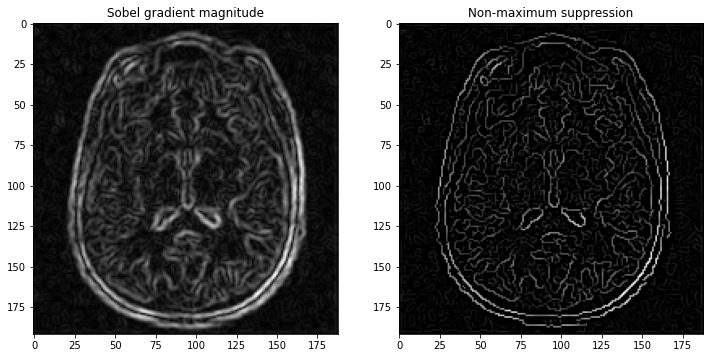

In [6]:
# ====== YOUR CODE: ======
plt.figure(figsize=(12,12))

plt.subplot(1,2,1)
plt.title('Sobel gradient magnitude')
plt.imshow(magnitude_img, cmap='gray')

plt.subplot(1,2,2)
non_max_img = non_max_suppression(magnitude_img, direction_img)
plt.title('Non-maximum suppression')
plt.imshow(non_max_img, cmap='gray')

plt.show()
# ========================

5. After thinning the edges, we're left with high and low magnitude edges. We would like to filter out all the insignificant edges.
Implement the function `double_threshold` that gets an edge image and two thresholds and returns an image containing three values: 0 for background, 1 for weak edges, and 2 for strong edges.<br>
Write a description of your function and explain its inputs and output.

In [7]:
def double_threshold(edges: np.ndarray, lowThresholdRatio: float, highThresholdRatio: float) -> np.ndarray:
    '''
    The function will get two thresholds and return an edge image suitable to the thresholds.
    the image will contain: 0 for background, 1 for weak edges, and 2 for strong edges.
    
    :param edges: numpy array of an edge image
    :param lowThresholdRatio: below this threshold the image will get a backround value
    :param highThresholdRatio: above this threshold the image will get an strong edge value
    :return img_tresh: an image containing the values 0, 1, 2.
    '''
    # ====== YOUR CODE: ======
    img_thresh = np.ones_like(edges)
    img_thresh[edges>highThresholdRatio] = 2
    img_thresh[edges<lowThresholdRatio] = 0
            
    # ========================
    return img_thresh

6. Use the above function to thin the edge map you computed in the previous part of this section.  Experiment to find good parameters of this operation. 
    Display in one figure the result produced by your `non_max_suppression` before and applying `double_threshold`. Add titles to your figure.

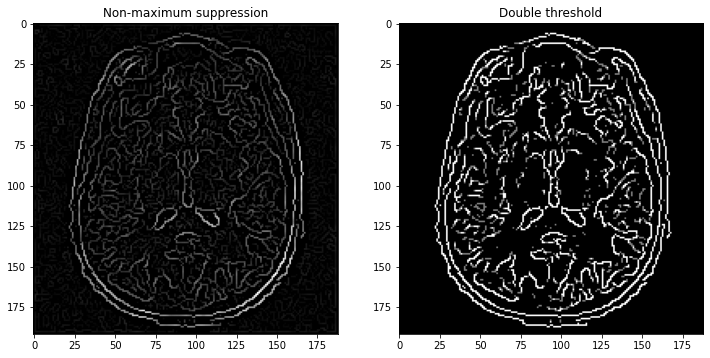

In [8]:
# ====== YOUR CODE: ======
plt.figure(figsize=(12,12))

plt.subplot(1,2,1)
plt.title('Non-maximum suppression')
plt.imshow(non_max_img, cmap='gray')

plt.subplot(1,2,2)
double_th_img = double_threshold(non_max_img, lowThresholdRatio=15, highThresholdRatio=20)
plt.title('Double threshold')
plt.imshow(double_th_img, cmap='gray')

plt.show()
# ========================

7. The last step of Canny edge detector implementation is filtering the isolated weak edges and keeping only the strong edges and those that are connected to them. You can assume a neighborhood of 3X3. 
    Implement the function `hysteresis` that performs the describe above.  <br>
    Write a description of your function and explain its inputs and output.

In [9]:
def hysteresis(edges: np.ndarray) -> np.ndarray:
    '''
    The function is filtering the isolated weak edges and keeping only the strong edges 
    and those that are connected to them.
    
    :param edges: numpy array of an edge image containing the values 0, 1, 2.
    :return hysteresis: numpy array of an binary edge image.
    '''
    # ====== YOUR CODE: ======
    hysteresis = np.copy(edges)
    
    for r_idx, row in enumerate(edges):
        for c_idx, cell in enumerate(row):   
            if cell == 1: 
                tmp_mat = hysteresis[r_idx-1:r_idx+2, c_idx-1:c_idx+2]
                if 2 in tmp_mat:
                    hysteresis[r_idx, c_idx] = 2
                else:
                    hysteresis[r_idx, c_idx] = 0
                    
    hysteresis[hysteresis==2] = 1
    # ========================    
    return hysteresis

8. Let's get the final edges image of the brain. Take the thinned edge map you computed in the previous part of this section and use the `hysteresis` function to get the final edges image of the brain. Display in one figure the image before and after applying the hysteresis and titles. 


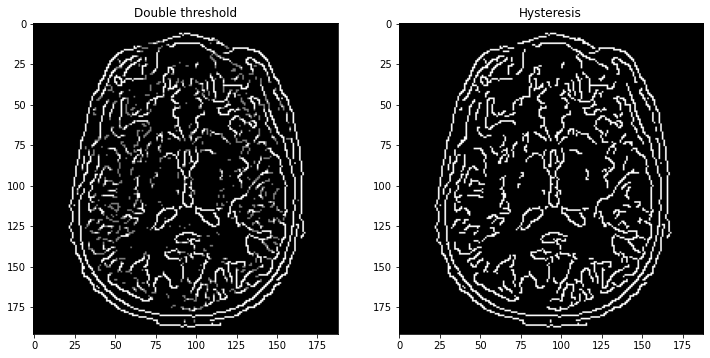

In [10]:
# ====== YOUR CODE: ======
plt.figure(figsize=(12,12))

plt.subplot(1,2,1)
plt.title('Double threshold')
plt.imshow(double_th_img, cmap='gray')

plt.subplot(1,2,2)
hysteresis_img = hysteresis(double_th_img)
plt.title('Hysteresis')
plt.imshow(hysteresis_img, cmap='gray')

plt.show()
# ========================

9. You used the Canny edge detector to get the edges of an image. However, you got an unsatisfied result; false edges appeared and long edges were broken into short ones separated by gaps. 
* How can you adjust the hysteresis thresholding to improve the edge detection.
* What could cause the false edges? Suggest a way to avoid the false edges (except to adjust the hysteresis thresholding)

**Answer:**

* I can extend the neighborhood to be bigger then 3x3.
* Noise in the image, low contrast, blured image, etc. can cause false edges. <br>
    We can filter the image with more filter (except from the gaussian), sharpen it and enhance the contrast.

---

## Exercise 2

In this exercise we will implement Hough Circle Transform.<br>
1. The first step we have to do is preprocess the image to get a binary image that represents its edges.<br>
    Load the image 'coins.jpg' and get its edges image using the `Canny` function of cv2 library. Display in one figure the original image and its edges and add titles. 

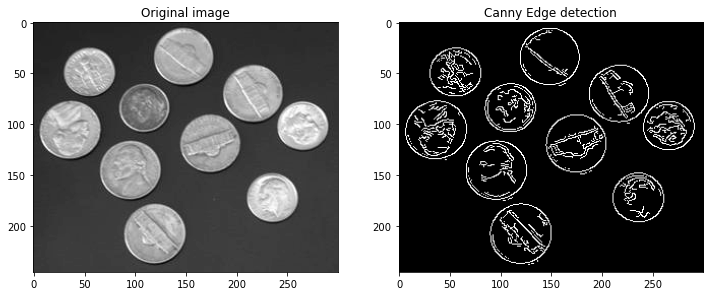

In [11]:
# ====== YOUR CODE: ======
t_lower=100
t_upper=200

plt.figure(figsize=(12,12))

plt.subplot(1,2,1)
coins_img = plt.imread('coins.jpg')
plt.title('Original image')
plt.imshow(coins_img, cmap='gray')

plt.subplot(1,2,2)
edges_img = cv2.Canny(coins_img, t_lower, t_upper)
plt.title('Canny Edge detection')
plt.imshow(edges_img, cmap='gray')

plt.show()
# ========================

2. For Hough Circle Transform we need three parameters to define a circle: $(x_{center}, y_{center}, r)$ <br>
where $(x_{center},y_{center})$ define the center position and $r$ is the radius.
It means that in this case the accumolator matrix would be a 3D matrix.<br>
Implenent the function `circles_accumolator` that gets a binary image that repersents the image edges and an array of the different radiuses to search circles at, and return the accomultor matrix in the hough space. 


In [12]:
def circles_accumolator(img:np.ndarray, radius:np.ndarray)-> np.ndarray:
    '''
    The function returns an hough transform accumolation matrix of an edge image.
    
    :param img: numpy array of a binary image that repersents an image edges
    :param radius: numpy array of the different radiuses to search circles at
    :return hough_domain: numpy array of an 3d accomultor matrix in the hough space
    '''
    # ====== YOUR CODE: ======
    hough_domain = np.zeros([img.shape[1]+1, 
                             img.shape[1]+1, 
                             np.max(radius)+1])
    
    angles = np.arange(0, 360) * np.pi/180
    
    for x, row in enumerate(img):
        for y, cell in enumerate(row):
            if cell > 0:
                for r in radius:
                    for theta in angles:
                        a = x + int(r*np.cos(theta)) # columns
                        b = y + int(r*np.sin(theta)) # rows
                        if 0<a<img.shape[1] and 0<b<img.shape[1]:
                            hough_domain[a, b, r] += 1
    # ========================    
    return hough_domain

4. Implement the function `hough_circles` that gets image of edges, computes the accomultor matrix in the hough space and return the parameters (a,b,r) of each detected circle on the image. Choose the detected circle acorrding to votes threshold and distance thresholds that represents the minimal distance between the centers of two different circles. 

In [13]:
def hough_circles(img, radius, votes_thresh, dist_thresh):
    '''
    The function gets image of edges, computes the accomultor matrix in the hough space 
    and return the parameters (a,b,r) of each detected circle on the image.
    
    :param img: numpy array of a binary image that repersents an image edges
    :param radius: numpy array of different radiuses to search circles at
    :param votes_thresh: votes per H[a, b, r] threshold
    :param dist_thresh: distance threshold that represents the minimal distance between 
                        the centers of two different circles
    :return circles: numpy array of the circles (a, b, r) in the image 
    '''
    # ====== YOUR CODE: ======
    circles_above_votes_thresh = []
    circles_distance = {}
    
    acc_matrix = circles_accumolator(img, radius)
    
    for array, counter in np.ndenumerate(acc_matrix):
        if counter > votes_thresh:
            circles_above_votes_thresh.append([array[0], array[1], array[2]])

    circles = [circles_above_votes_thresh[0]]
                
    for array in circles_above_votes_thresh:
        a, b, r1 = array
        vote = acc_matrix[a, b, r1]
        circle_ok = 0
        arrays_to_delete = []

        for idx, array2 in enumerate(circles):
            c, d, r2 = array2
            distance = np.linalg.norm(np.array([a, b])-np.array([c, d]))
            vote2 = acc_matrix[c, d, r2]

            if distance == 0 and r1==r2:  # same circle
                continue

            if distance > dist_thresh:
                circle_ok += 1

            elif distance < dist_thresh and vote > vote2:
                circle_ok += 1
                arrays_to_delete.append(idx)

        if circle_ok == len(circles):
            circles = list(circles)
            circles.append(array)
            for idx in arrays_to_delete:
                circles = np.delete(circles, idx, 0)
        # ========================   
    return circles

5. Let's detect the coins in the image using your functions. Take the edges image of the coins, set the radius vector, votes threshold and distance thresholds, and get the detected circles parameters using the function `hough_circles`. Experiment to find the best parameters that yield the optimal coins detections. <br>
    Draw the detected circles on the original image of coins and display it in a figure. You may use the function `plt.Circle`. 

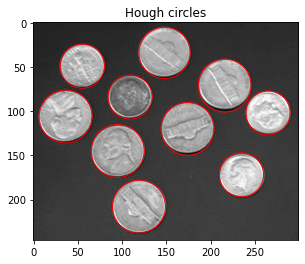

In [14]:
# ====== YOUR CODE: ======
radius = np.arange(22, 40)
votes_thresh = 150
dist_thresh = 30

circles = hough_circles(edges_img, radius, votes_thresh, dist_thresh)
plt.title('Hough circles')
plt.imshow(coins_img, cmap='gray')
ax = plt.gca()

for array in circles:
    a, b, r = array
    circle = plt.Circle((b, a), r, color='r', fill=False)
    ax.add_patch(circle)
    
plt.show()
# ========================

 6. **Bunos**<br>
5 points

    Implement the function `draw_circles` that draws a circle on a given image and plots the image with the circles (using only basic numpy functions).<br>
Use this function to draw the detected circles on the original image of coins and display it in a figure. 

In [15]:
def draw_circles(img, circle_params):
    '''
    Add your description and complete the inputs (params) and output (return).
    
    :param img: 
    :param circle_params:
    '''
    # ====== YOUR CODE: ======

    # ========================   

    return 

7. Given two points at (3,2) and (5,10) in the image space:
    * Describe the corresponding hough space of the parameters m,c.
    * Describe what the accumulator matrix would look like. Would you get a maximum in the matrix? If so,  where and what is the maximum value?  

**Answer:**

* The hough space: $y = m*x+c$
* The matrix will be 2d: H(m, c). <br>
    The max supposed to be: <br>
    $m = \frac{10-2}{5-3}\ = \frac{8}{2}\ = 4$ <br>
    $c = 10 - 4*5 = -10$ <br>
    It is the values of the line between the two dots. <br>
    We will not get it in the matrix because the c index in negetive.
    